Rahmatur Ramadhan
1301184468<br>

# Prerequisites

In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
train = pd.read_csv('DMC_2019_task/train.csv', sep='|')
test = pd.read_csv('DMC_2019_task/test.csv', sep='|')
truth = pd.read_csv('DMC-2019-realclass.csv', sep='|').values.flatten()
print(train.shape)
print(test.shape)
print(truth.shape)

(1879, 10)
(498121, 9)
(498121,)


In [9]:
train.info()

# Data Overview

**Dataset Description**

This dataset is a dataset from a *self-checkout* machine in a shop that is currently testing a machine that allows buyers to input the purchased items and then pay for them independently. This dataset has a *fraud* column that shows whether a transaction is included in the fraud category or not.

**Columns Description** <br>
**trustLevel** : A customer’s individual trust level. 6 means Highest trustworthiness <br>
**totalScanTimeInSeconds** : Total time in seconds between the first and last product scanned <br>
**grandTotal** : Grand total of products scanned <br>
**lineItemVoids** : Number of voided scans <br>
**scansWithoutRegistration** : Number of attempts to activate the scanner without actually scanning anything <br>
**quantityModification** : Number of modified quantities for one of the scanned products <br>
**scannedLineItemsPerSecond** : Average number of scanned products per second <br>
**valuePerSecond** : Average total value of scanned products per second <br>
**lineItemVoidsPerPosition** : Average number of item
voids per total number of all scanned and not cancelled products <br>
**fraud** : Classification as fraud (1) or not fraud (0)




**Fact**: Each column affects each other (Multicollinearity)

**Hypothesis**: If you want to scale the data, use a standard scaler.

**Hypothesis**: We can get the number of purchased items by multiplying the columns *totalScanTimeInSeconds* and *scannedLineItemsPerSecond*

In [3]:
train

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
...,...,...,...,...,...,...,...,...,...,...
1874,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,0
1875,1,397,41.89,5,5,0,0.065491,0.105516,0.192308,1
1876,4,316,41.83,5,8,1,0.094937,0.132373,0.166667,0
1877,2,685,62.68,1,6,2,0.035036,0.091504,0.041667,0


**Fact**: This data is very unbalanced. Of the 1879 training data, only 5% of the data is fraudulent transaction data

**Hypothesis**: In the process of determining the model to be used in the classification process, cross validation must be carried out to ensure that the selected model is the model that has the highest performance.

**Hypothesis**: Evaluation metrics that are suitable for this data are precision, recall and f1 score in the *fraud* label.

In [4]:
pd.Series(data=[len(train),len(test)],index=['train','test'])

train      1879
test     498121
dtype: int64

fraud percent = 5.534858967535923 %


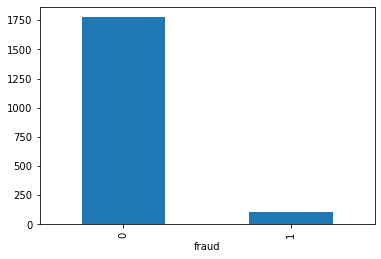

In [5]:
train.groupby('fraud').size().plot(kind='bar')
print('fraud percent =',len(train[train.fraud == 1])/len(train)*100,'%')

**Facts**: It can be seen that in the training data, all data categorized as fraud have a low individual trust level, between 1 or 2 only.

**Hypothesis**: Models with linear-based models can distinguish fraud well because of this fact

In [6]:
train[train.fraud == 1].trustLevel.unique()

array([1, 2], dtype=int64)

**Fact**: in the *lineItemVoidsPerPosition*, *valuePerSecond* and *scannedLineItemsPerSecond* columns it can be seen that there are outliers in this dataset. This is inferred from looking at the average, 75% and max of these columns. The mean and 75% of the columns are far from the largest data in that column.

**Hypothesis**: it seems that fraud data is outlier data

In [7]:
train.describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,3.401809,932.153273,50.864492,5.469931,4.904204,2.525279,0.058138,0.201746,0.745404,0.055349
std,1.709404,530.144640,28.940202,3.451169,3.139697,1.695472,0.278512,1.242135,1.327241,0.228720
min,1.000000,2.000000,0.010000,0.000000,0.000000,0.000000,0.000548,0.000007,0.000000,0.000000
25%,2.000000,474.500000,25.965000,2.000000,2.000000,1.000000,0.008384,0.027787,0.160000,0.000000
50%,3.000000,932.000000,51.210000,5.000000,5.000000,3.000000,0.016317,0.054498,0.350000,0.000000
75%,5.000000,1397.000000,77.285000,8.000000,8.000000,4.000000,0.032594,0.107313,0.666667,0.000000
max,6.000000,1831.000000,99.960000,11.000000,10.000000,5.000000,6.666667,37.870000,11.000000,1.000000


**Facts**: The previous hypothesis is not correct, it turns out that outliers in this dataset are not a sign that the data is fraud. Because based on the mean, 75% and max of the fraud data, there is no data that is far adrift (outliers).

**Hypothesis**: removing outliers cannot affect fraud detection. But it might make it easier to detect non-fraud transactions.

In [8]:
train[train.fraud == 1].describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.0
mean,1.144231,1173.913462,51.034327,6.375000,5.865385,2.519231,0.031582,0.053622,0.251412,1.0
std,0.353025,471.260881,30.298933,3.498092,3.211199,1.654536,0.034298,0.045918,0.146440,0.0
min,1.000000,91.000000,0.260000,0.000000,0.000000,0.000000,0.011692,0.000661,0.000000,1.0
25%,1.000000,819.000000,27.072500,3.000000,3.000000,1.000000,0.016411,0.026209,0.130435,1.0
50%,1.000000,1309.500000,48.670000,6.000000,7.000000,2.000000,0.020436,0.043697,0.245000,1.0
75%,1.000000,1540.500000,76.862500,10.000000,8.250000,4.000000,0.033966,0.071838,0.379721,1.0
max,2.000000,1830.000000,99.820000,11.000000,10.000000,5.000000,0.307692,0.230802,0.578947,1.0


**Facts**: The following are the feature importance of the columns in this dataset using the Pearson correlation algorithm.

**Hypothesis**: Columns that have a correlation of -0.05 < x < 0.05 can not be used because they do not significantly affect the change in the value in the fraud column.

In [9]:
train.corr().fraud

trustLevel                  -0.319765
totalScanTimeInSeconds       0.110414
grandTotal                   0.001421
lineItemVoids                0.063496
scansWithoutRegistration     0.074123
quantityModifications       -0.000864
scannedLineItemsPerSecond   -0.023085
valuePerSecond              -0.028873
lineItemVoidsPerPosition    -0.090116
fraud                        1.000000
Name: fraud, dtype: float64

# Feature Engineering & Data Preprocessing

**TO-DO**:
* Add column 'totalItems' which contains the number of items purchased in one transaction
* see the correlation to the fraud column

In [10]:
train['totalItems'] = [train.iloc[i].totalScanTimeInSeconds * train.iloc[i].scannedLineItemsPerSecond for i in tqdm(range(len(train)))]
test['totalItems'] = [test.iloc[i].totalScanTimeInSeconds * test.iloc[i].scannedLineItemsPerSecond for i in tqdm(range(len(test)))]

100%|██████████| 498121/498121 [02:11<00:00, 3774.18it/s]


In [11]:
train.corr().totalItems.fraud

0.29842339148455455

**TO-DO**:
* Look for the column whose feature importance is -0.05 < x < 0.05
* Drop the column
* Create variables X, X_test, y that are ready to be used for the model

In [12]:
corr = train.corr().fraud
todrop = [i for i in corr.index if corr[i] < 0.05 and corr[i] > -0.05]
todrop

['grandTotal',
 'quantityModifications',
 'scannedLineItemsPerSecond',
 'valuePerSecond']

In [13]:
X = train.drop(columns=todrop+['fraud'])
X_test = test.drop(columns=todrop)
y = train.fraud.values

**TO-DO**:
* Scale the dataset using the Standard Scaler. So that models that do not have a built-in scaler such as SVM or Logistic Regression can fit better and reach convergence more quickly.

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Defining Additional Evaluation Metrics

In the Data Mining Cup 2019, additional evaluation metrics in the form of reward 
<br>punishment are also given that the data uses as a moral compass to determine 
<br>how many false positives and false negatives are reasonable for a model. 
<br>The following is the cost matrix given for the Data Mining Cup 2019:

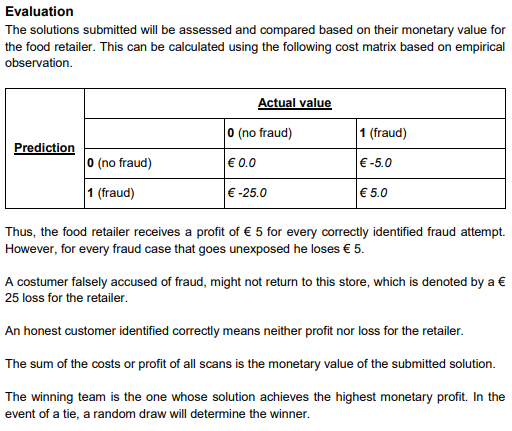

In [15]:
def evaluate(actual, pred, pri=True, ret='all'):
    tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
    if pri:
      print('TN =',tn,', FP =', fp,', FN =', fn,', TP =',tp)
      print((tp*5) + (tn*0) + (fp*-25) + (fn*-5),'/', len(actual[actual == 1]) * 5)
      print('current monetary profit / highest monetary profit that possible')
    if ret != None:
      if ret == 'all':
        return (tp*5) + (tn*0) + (fp*-25) + (fn*-5)
      elif ret == 'fpfn':
        return fp+fn
      elif ret == 'fp':
        return fp
      elif ret == 'fn':
        return fn

# Find The Best Performance Baseline Model with Cross Validation

In [16]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [17]:
models = {
    'Naive Bayes' : GaussianNB(), #Naive Bayes
    'Logistic Regression' : LogisticRegression(), #Linear Model
    'Linear SVC' : LinearSVC(), #Support Vector
    'SVC rbf': SVC(kernel='rbf',probability=True),#Support Vector
    'SVC poly': SVC(kernel='poly', probability=True),#Support Vector
    'Decision Tree': DecisionTreeClassifier(), #Tree
    'MLP' : MLPClassifier(random_state=12,hidden_layer_sizes=(100),max_iter=1000), #Neural Network
    'KNN' : KNeighborsClassifier(), #Nearest Neighbor
}

In the following results, focus on the FP and FN of each model prediction result:

In [18]:
for key, clf in models.items():
    print('Model :',key)
    pred = cross_val_predict(clf, X, y, cv=10) #do cross validation with 10 fold
    print(classification_report(y, pred))
    print('FP+FN =',evaluate(y,pred,ret='fpfn'))
    print('============================================')

Model : Naive Bayes
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1775
           1       0.64      0.92      0.75       104

    accuracy                           0.97      1879
   macro avg       0.82      0.95      0.87      1879
weighted avg       0.98      0.97      0.97      1879

TN = 1720 , FP = 55 , FN = 8 , TP = 96
-935 / 520
current monetary profit / highest monetary profit that possible
FP+FN = 63
Model : Logistic Regression
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1775
           1       0.95      0.87      0.90       104

    accuracy                           0.99      1879
   macro avg       0.97      0.93      0.95      1879
weighted avg       0.99      0.99      0.99      1879

TN = 1770 , FP = 5 , FN = 14 , TP = 90
255 / 520
current monetary profit / highest monetary profit that possible
FP+FN = 19
Model : Linear SVC
              precision    rec

### Performance of Best Baseline Model Against Test Data and Ground Truth

In [19]:
clf = GaussianNB()
clf.fit(X,y)
pred = clf.predict(X_test)
print(classification_report(truth, pred))
print('FP+FN =',evaluate(truth,pred,ret='fpfn'))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    474394
           1       0.60      0.96      0.74     23727

    accuracy                           0.97    498121
   macro avg       0.80      0.96      0.86    498121
weighted avg       0.98      0.97      0.97    498121

TN = 459170 , FP = 15224 , FN = 1063 , TP = 22664
-272595 / 118635
current monetary profit / highest monetary profit that possible
FP+FN = 16287


In [20]:
clf = LinearSVC()
clf.fit(X,y)
pred = clf.predict(X_test)
print(classification_report(truth, pred))
print('FP+FN =',evaluate(truth,pred,ret='fpfn'))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    474394
           1       0.90      0.90      0.90     23727

    accuracy                           0.99    498121
   macro avg       0.95      0.95      0.95    498121
weighted avg       0.99      0.99      0.99    498121

TN = 471969 , FP = 2425 , FN = 2484 , TP = 21243
33170 / 118635
current monetary profit / highest monetary profit that possible
FP+FN = 4909


In [21]:
clf = SVC(kernel='poly', probability=True)
clf.fit(X,y)
pred = clf.predict(X_test)
print(classification_report(truth, pred))
print('FP+FN =',evaluate(truth,pred,ret='fpfn'))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    474394
           1       0.93      0.81      0.87     23727

    accuracy                           0.99    498121
   macro avg       0.96      0.90      0.93    498121
weighted avg       0.99      0.99      0.99    498121

TN = 472984 , FP = 1410 , FN = 4438 , TP = 19289
39005 / 118635
current monetary profit / highest monetary profit that possible
FP+FN = 5848


In [22]:
clf = MLPClassifier(random_state=12,hidden_layer_sizes=(100),max_iter=1000)
clf.fit(X,y)
pred = clf.predict(X_test)
print(classification_report(truth, pred))
print('FP+FN =',evaluate(truth,pred,ret='fpfn'))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    474394
           1       0.90      0.88      0.89     23727

    accuracy                           0.99    498121
   macro avg       0.95      0.94      0.94    498121
weighted avg       0.99      0.99      0.99    498121

TN = 472107 , FP = 2287 , FN = 2731 , TP = 20996
34150 / 118635
current monetary profit / highest monetary profit that possible
FP+FN = 5018


**Best Baseline Model**

In [23]:
clf = LogisticRegression()
clf.fit(X,y)
pred = clf.predict(X_test)
print(classification_report(truth, pred))
print('FP+FN =',evaluate(truth,pred,ret='fpfn'))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    474394
           1       0.93      0.86      0.89     23727

    accuracy                           0.99    498121
   macro avg       0.96      0.93      0.94    498121
weighted avg       0.99      0.99      0.99    498121

TN = 472889 , FP = 1505 , FN = 3380 , TP = 20347
47210 / 118635
current monetary profit / highest monetary profit that possible
FP+FN = 4885


Can be concluded that:
* Logistic Regression is better than SVC poly because it can classify fraud with the highest monetary profit in the test data. Logistic Regression gets the lowest FP but high False Negative
* MLP and Linear SVC can classify fraud with relatively stable FP and FN and can be accepted with stable reasons.
* Naive Bayes can classify data with low FN, this makes the TP value higher. This model is suitable if there is no problem when there is a False Positive. However, in this case False Positive can make customers not want to shop at this store because they are accused of cheating when they are not.

Since this model is based on monetary profit, the best baseline model is Logistic Regression with a monetary profit of €47,210 and the number of misclassifications (FP+FN) of 4,885 transactions